# ICESAT vs TOPAZ

In [1]:
import pickle
import numpy as np
import datetime

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap


from src.utils import modif_plot
from src.utils import quickplot
from src.utils import save_name
from src.data_preparation import load_data

import src.utils.tardisml_utils as tardisml_utils
rootdir = tardisml_utils.get_rootdir()

In [2]:
# -----------------------------------
#          Functions
# -----------------------------------



def get_tindex_period(chrono, d1, d2):
    '''Returns indexes in TOPAZ between 2 datetime objects
    
    Parameters:
    -----------
        chrono   :       chrono from TOPAZ4
        d1       :       datetime object, first date in date
        d2       :       datetime object, lastest date in date
    '''
    # identify index to plot
    chrono_dt = np.array([dt.date() for dt in chrono.date])
    idx_min = np.where(chrono_dt==d1)[0]
    idx_max = np.where(chrono_dt==d2)[0]    
    
    return np.arange(idx_min, idx_max+1)


def get_closest_mean_std(lat, lon, tmin, tmax, sit_tp, chrono):
    '''
    Returns TOPAZ SIT (mean and std) for closest point in space and over time interval
    for one given (lat, lon) point (from ICESAT campaigns)
    
    Parameters:
    -----------
        lat           :    latitude of one given point
        lon           :    longitude of one given point
        tmin          :    datetime object, first date of one given point
        tmax          :    datetime object, last date of one given point
        sit_tp        :    xarray.DataArray, Sea Ice Thickness ML-corrected from TOPAZ4
        chrono        :    panda.DataFrame, dates associated to sit_tp
    
    '''

    # for oone given (lat,lon) point
    # get time index between Time min and Time max
    tloc = get_tindex_period(chrono, t_min, t_max)
    
    # localise the closest TOPAZ points for the (lat, lon) point
    # from https://stackoverflow.com/questions/58758480/xarray-select-nearest-lat-lon-with-multi-dimension-coordinates
    # First, find the index of the grid point nearest a specific lat/lon.   
    abslat = np.abs(sit.latitude-lat)
    abslon = np.abs(sit.longitude-lon)
    c = np.maximum(abslon, abslat)
    closest = np.where(c == np.min(c))
    
    if closest[0].size > 1:  # rare case where one (lat,lon) point is at equal distance of 2 grid points
        # then we just pick the first one
        yloc = closest[0][0]
        xloc = closest[1][0]
    else:
        ([yloc], [xloc]) = closest
    
    point_ds = sit_tp.isel(time=tloc, x=xloc, y=yloc)
    
    # print(f'TOPAZ4 global corrected with RF, SIT: {point_ds.mean().data}')
    # print(f'ICESAT , SIT: {dico_ice["Avg_thkns"][index][pi]}')
    
    # return np.array([point_ds.mean(), point_ds.std()])  # return mean and std
    return point_ds  # return all points



def double_basemap(lats, lons, sit_obs, sit_tp, suptitle='', odir='', ofile='', savefig=False, showfig=True, **kwargs):
    '''
    Parameters:
    -----------
    
        sit_obs      : Sea Ice Thickness from ICESAT (or other)
        sit_tp       : Sea Ice Thickness from ToPaz
    
    '''
    
    
#     fig = plt.figure(figsize=((1920/103)/1.5,1200/103),dpi=103)
    
    fig, axes = plt.subplots(ncols=2, figsize=(9*2, 9), constrained_layout=True)
    
    m = Basemap(projection='npstere', boundinglat=58, lon_0=0, resolution='l', round=True, ax=axes[0])
    m.drawcoastlines()
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    m.scatter(lons, lats, c=sit_obs, lw=0, latlon=True, zorder=10, **kwargs)
    # cbar = plt.colorbar(cs)
    # cbar.set_label('{}'.format(label_cb))
    axes[0].set_title('ICESAT')
    
    
    m2 = Basemap(projection='npstere', boundinglat=58, lon_0=0, resolution='l', round=True, ax=axes[1])
    m2.drawcoastlines()
    m2.drawparallels(np.arange(-80.,81.,20.))
    m2.drawmeridians(np.arange(-180.,181.,20.))
    cs2 = m2.scatter(lons, lats, c=sit_tp, lw=0, latlon=True, zorder=10, **kwargs)
    axes[1].set_title('TOPAZ')
    
    
    fig.colorbar(cs2, ax=axes, shrink=0.3, location="bottom", extend='max')
    
    fig.suptitle(suptitle)
    modif_plot.resize(fig, s=24)
    
    if savefig:
        if ofile=='':
            return
        
        ofile = save_name.check(f"{odir}", ofile)
        plt.savefig(f"{odir}{ofile}", dpi=124, facecolor='white')
        print(f'Figure saved as : {odir}{ofile}')
        
    if showfig:
        plt.show()
        
    plt.close()

    
def draw_violin_scatter(sit_obs, sit_tp, suptitle='', odir='', ofile='', savefig=False, showfig=True):
    '''
    '''
    
    fig, axes = plt.subplots(ncols=2, figsize=(9*2, 9), constrained_layout=True)
    
    
    axes[0].violinplot(sit_obs, [0], showmeans=True)
    axes[0].violinplot(sit_tp[~np.isnan(sit_tp)], [1], showmeans=True)
    
    axes[0].set_xlabel('')
    axes[0].set_ylabel('SIT (m)')
    
    axes[0].set_xticks([0,1])
    axes[0].set_xticklabels(['ICESAT', 'TOPAZ'])

    
    axes[1].scatter(sit_obs, sit_tp)
    mini = np.floor(np.nanmin([sit_obs, sit_tp]))
    maxi = np.ceil(np.nanmax([sit_obs, sit_tp]))   
    axes[1].plot([mini, maxi], [mini, maxi], '--', c='grey')  # , zorder=-10)

    axes[1].set_xlabel('ICESAT')
    axes[1].set_ylabel('TOPAZ')
    axes[1].set_xlim(0, maxi)
    axes[1].set_ylim(0, maxi)
    
    fig.suptitle(suptitle)
    modif_plot.resize(fig, s=24, rx=0)

    if savefig:
        if ofile=='':
            return
        
        ofile = save_name.check(f"{odir}", ofile)
        plt.savefig(f"{odir}{ofile}", dpi=124, facecolor='white')
        print(f'Figure saved as : {odir}{ofile}')
        
    if showfig:
        plt.show()

    plt.close()
    
    

In [2]:
# -----------------------------------
#           Imports
# -----------------------------------

#         Load ICESAT
# -----------------------------------

odir = f'{rootdir}Leo/SIT_observations/unified_processed/'
ofile = f'ICESAT-G_summaries_SIT.pkl'
dico_ice = pickle.load(open(f'{odir}{ofile}','rb'))
cruises = np.unique(dico_ice['Cruise'])  # different campaigns


# Time to datetime
years = dico_ice['Year']
days = dico_ice['Yday']
dt = np.array([datetime.date(year,1,1)+datetime.timedelta(days=int(day_num)-1) for year, day_num in zip(years, days)])
dt_min = np.array([datetime.date(year,1,1)+datetime.timedelta(days=int(day_num)-1) for year, day_num in zip(years, dico_ice['MinDay'])])
dt_max = np.array([datetime.date(year,1,1)+datetime.timedelta(days=int(day_num)-1) for year, day_num in zip(years, dico_ice['MaxDay'])])
    

In [4]:
dt_min

array([datetime.date(2003, 3, 5), datetime.date(2003, 3, 8),
       datetime.date(2003, 2, 21), ..., datetime.date(2008, 10, 10),
       datetime.date(2008, 10, 9), datetime.date(2008, 10, 11)],
      dtype=object)

In [5]:
dt_max

array([datetime.date(2003, 3, 13), datetime.date(2003, 3, 16),
       datetime.date(2003, 3, 17), ..., datetime.date(2008, 10, 18),
       datetime.date(2008, 10, 17), datetime.date(2008, 10, 16)],
      dtype=object)

In [7]:
cruises

array(['1', '2a', '2b', '2c', '3a', '3b', '3c', '3d', '3e', '3f', '3g',
       '3h', '3i', '3j', '3k'], dtype='<U12')

In [8]:
print('Loading complete.')
# camp = '3b'

for camp in cruises:

    index = np.where((dico_ice['Cruise']==camp))
    t_min = np.min(dt_min[np.where(dico_ice['Cruise']==camp)])
    t_max = np.max(dt_max[np.where(dico_ice['Cruise']==camp)])
    print(f'Campaign {camp}: from {t_min} to {t_max}')

Loading complete.
Campaign 1: from 2003-02-20 to 2003-03-20
Campaign 2a: from 2003-10-04 to 2003-11-18
Campaign 2b: from 2004-02-17 to 2004-03-21
Campaign 2c: from 2004-05-18 to 2004-06-21
Campaign 3a: from 2004-10-03 to 2004-11-08
Campaign 3b: from 2005-02-17 to 2005-03-24
Campaign 3c: from 2005-05-20 to 2005-06-23
Campaign 3d: from 2005-10-21 to 2005-11-24
Campaign 3e: from 2006-02-22 to 2006-03-28
Campaign 3f: from 2006-05-24 to 2006-06-26
Campaign 3g: from 2006-10-25 to 2006-11-27
Campaign 3h: from 2007-03-12 to 2007-04-14
Campaign 3i: from 2007-10-02 to 2007-11-05
Campaign 3j: from 2008-02-17 to 2008-03-21
Campaign 3k: from 2008-10-04 to 2008-10-19


In [4]:
#         Load TOPAZ 2000-2010
# -----------------------------------

# global prediction RF:  (as example)
# filename = f'{rootdir}Leo/results/rf_221229-171734/ml/sit_ml_2000_2011.nc'
# ml_model = 'RF'

#filename = f'{rootdir}Leo/results/xgb_221230-121451/ml/sit_ml_2000_2011.nc'
# ml_model = 'XGB'

filename = f'{rootdir}Leo/results/lstm_230201-112355/ml/sit_ml_2000_2011.nc'
ml_model = 'LSTM'

# filename = f'{rootdir}Leo/results/cnn_230131-175505/ml/sit_ml_2000_2011.nc'
# ml_model = 'CNN'

sit, chrono = load_data.load_nc(filename, 'sit_ml', X_only=True)

# sit, chrono = load_data.load_nc(filename, 'sit_na', X_only=True)  # from Topaz4 FreeRun
# ml_model = 'FreeRun'


# Cap negative value at 0 m (while keeping nan)
sit = (sit.where((0<sit), 0)).where(np.isfinite(sit))
    
    
    

In [5]:
from src.modelling import sit_corrected

In [6]:
# ---------------------------------
#       Import all predictions
# ---------------------------------

### LSTM model
irootdir= f'{rootdir}'
ipath = 'Leo/results/lstm_230201-112355/'
ml_name ='LSTM'

ifile = f'{irootdir}{ipath}'
sitm = sit_corrected.SITCorrected(ifile, name=ml_name, verbose=1, objective='apply')



# ------------------------------------------------
##            Reconstruct SIT values 
# ------------------------------------------------

print('\nReconstructing SIT...')

sitm.reconstruct_sit()
sitm.compute_mean(sit_min=None)    

Config file found: /scratch/project_465000269/edelleo1/Leo/results/lstm_230201-112355/config_LSTM_no_bias_0wk.yaml
Folder: Leo/results/lstm_230201-112355/figures/sit_reconstruct/

Initialisation SIT from LSTM


/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PCA from version 1.1.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ML prediction .nc file found: /scratch/project_465000269/edelleo1/Leo/results/lstm_230201-112355/ml/ypred_LSTM3_bk_2000_2011.nc

Reconstructing SIT...


In [7]:
sit

<xarray.DataArray 'sit_ml' (time: 4383, y: 329, x: 450)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2011-12-31
    latitude   (y, x) float32 62.74 62.83 62.92 63.01 ... 56.49 56.41 56.33
    longitude  (y, x) float32 -100.5 -100.4 -100.3 -100.1 ... 82.73 82.61 82.5
  * x          (x) float32 -25.5 -25.38 -25.25 -25.12 ... 30.25 30.38 30.5 30.62
  * y          (y) float32 -17.5 -17.38 -17.25 -17.12 ... 23.12 23.25 23.38 23.5

In [8]:
sitm.sit

<xarray.DataArray (time: 4339, y: 329, x: 450)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2011-11-17
  * x          (x) float32 -25.5 -25.38 -25.25 -25.12 ... 30.25 30.38 30.5 30.62
  * y          (y) float32 -17.5 -17.38 -17.25 -17.12 ... 23.12 23.25 23.38 23.5
    latitude   (y, x) float32 62.74 62.83 62.92 63.01 ... 56.49 56.41 56.33
    longitude  (y, x) float32 -100.5 -100.4 -100.3 -100.1 ... 82.73 82.61 82.5

In [9]:
sitm.sit_bl

<xarray.DataArray 'sithick' (time: 4383, y: 329, x: 450)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2011-12-31
    latitude   (y, x) float32 ...
    longitude  (y, x) float32 ...
  * x          (x) float32 -25.5 -25.38 -25.25 -25.12 ... 30.25 30.38 30.5 30.62
  * y          (y) float32 -17.5 -17.38 -17.25 -17.12 ... 23.12 23.25 23.38 23.5
Attributes:
    cell_methods:   area: mean where sea_ice
    grid_mapping:   stereographic
    standard_name:  sea_ice_thickness
    units:          m

In [10]:
sitm.chrono

date
0    2000-01-01
1    2000-01-02
2    2000-01-03
3    2000-01-04
4    2000-01-05
...         ...
4334 2011-11-13
4335 2011-11-14
4336 2011-11-15
4337 2011-11-16
4338 2011-11-17

[4339 rows x 1 columns]

In [ ]:
# Compute baseline

In [12]:
cruises

array(['1', '2a', '2b', '2c', '3a', '3b', '3c', '3d', '3e', '3f', '3g',
       '3h', '3i', '3j', '3k'], dtype='<U12')

In [66]:
# -----------------------------------
#        Loop on campaigns
# -----------------------------------

print('Loading complete.')
# camp = '3b'

for camp in cruises:

    index = np.where((dico_ice['Cruise']==camp))
    t_min = np.min(dt_min[np.where(dico_ice['Cruise']==camp)])
    t_max = np.max(dt_max[np.where(dico_ice['Cruise']==camp)])
    print(f'Campaign {camp}: from {t_min} to {t_max}')

    # Get TOPAZ data for all ICESAT points
    tp_mean_std = np.zeros((len(index[0]),2))
    tp_bl_mean_std = np.zeros((len(index[0]),2))
    
    for ni, idx_pt in enumerate(index[0]):
        tp_mean_std[ni] = get_closest_mean_std(dico_ice['Lat'][idx_pt], dico_ice['Lon'][idx_pt], dt_min[idx_pt], dt_max[idx_pt], sit, chrono)
        tp_bl_mean_std[ni] = get_closest_mean_std(dico_ice['Lat'][idx_pt], dico_ice['Lon'][idx_pt], dt_min[idx_pt], dt_max[idx_pt], sitm.sit_bl, chrono)

    # point returned as np.nan means that closest TOPAZ grid point is on land
    idx_nan = np.unique(np.where(np.isnan(tp_mean_std))[0])
    print(f'Lost points because on land in TOPAZ:  {idx_nan.size}')

    #         Plot
    # -----------------------------------
    lons = dico_ice['Lon'][index]
    lats = dico_ice['Lat'][index]
    sit_obs = dico_ice['Avg_thkns'][index]
    sit_tp = tp_mean_std[:,0]
    sit_tp_bl = tp_bl_mean_std[:,0]
    
    t_min = np.min(dt_min[np.where(dico_ice['Cruise']==camp)])
    t_max = np.max(dt_max[np.where(dico_ice['Cruise']==camp)])
    title = f'Campaign {camp}: from {t_min} to {t_max}'

    # Map
    # odir = f'{rootdir}Leo/results/SIT_observations/'
    # ofile = f'ICESAT_TOPAZ{ml_model}_C{camp}_basemap.png'
    # double_basemap(lats, lons, sit_obs, sit_tp, suptitle=title, vmin=0, vmax=4, odir=odir, ofile=ofile, savefig=False, showfig=True)

        # Stats
    #     ofile = f'ICESAT_TOPAZ{ml_model}_C{camp}_violin_scatter.png'
    #     draw_violin_scatter(sit_obs, sit_tp, suptitle=title, odir=odir, ofile=ofile, savefig=False)


    # Get TOPAZ data for all ICESAT points
#     tp_bl_mean_std = np.zeros((len(index[0]),2))
#     for ni, idx_pt in enumerate(index[0]):
#         tp_bl_mean_std[ni] = get_closest_mean_std(dico_ice['Lat'][idx_pt], dico_ice['Lon'][idx_pt], dt_min[idx_pt], dt_max[idx_pt], sitm.sit_bl, chrono)

    # point returned as np.nan means that closest TOPAZ grid point is on land
#     idx_nan = np.unique(np.where(np.isnan(tp_bl_mean_std))[0])
#     print(f'Lost points because on land in TOPAZ:  {idx_nan.size}')

   
    odir = f'{rootdir}Leo/results/SIT_observations/ICESAT/002/'
    ofile = f'SIT_ICESAT_TOPAZLSTM_C{camp}_bs.png'

    draw_sit_baseline(lats, lons, sit_obs, sit_tp, sit_tp_bl, vmin=0, vmax=4, odir=odir, ofile=ofile, savefig=True, showfig=False)

    ofile = f'SITbias_ICESAT_TOPAZLSTM_C{camp}_bs.png'
    draw_bias_baseline(lats, lons, sit_obs, sit_tp-sit_obs, sit_tp_bl-sit_obs, odir=odir, ofile=ofile, savefig=True, showfig=False)

Loading complete.
Campaign 1: from 2003-02-20 to 2003-03-20


/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKK

/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKK

Lost points because on land in TOPAZ:  26


/tmp/ipykernel_173633/1719943804.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['0', '', '1','','2','','3','','4'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SIT_ICESAT_TOPAZLSTM_C1_bs.png


/tmp/ipykernel_173633/747113923.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['-2', '', '-1','','0','','1','','2'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SITbias_ICESAT_TOPAZLSTM_C1_bs.png
Campaign 2a: from 2003-10-04 to 2003-11-18


/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKK

/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Lost points because on land in TOPAZ:  22


/tmp/ipykernel_173633/1719943804.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['0', '', '1','','2','','3','','4'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SIT_ICESAT_TOPAZLSTM_C2a_bs.png


/tmp/ipykernel_173633/747113923.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['-2', '', '-1','','0','','1','','2'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SITbias_ICESAT_TOPAZLSTM_C2a_bs.png
Campaign 2b: from 2004-02-17 to 2004-03-21


/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKK

/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKK

Lost points because on land in TOPAZ:  37


/tmp/ipykernel_173633/1719943804.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['0', '', '1','','2','','3','','4'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SIT_ICESAT_TOPAZLSTM_C2b_bs.png


/tmp/ipykernel_173633/747113923.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['-2', '', '-1','','0','','1','','2'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SITbias_ICESAT_TOPAZLSTM_C2b_bs.png
Campaign 2c: from 2004-05-18 to 2004-06-21


/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKK

Lost points because on land in TOPAZ:  3


/tmp/ipykernel_173633/1719943804.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['0', '', '1','','2','','3','','4'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SIT_ICESAT_TOPAZLSTM_C2c_bs.png


/tmp/ipykernel_173633/747113923.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['-2', '', '-1','','0','','1','','2'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SITbias_ICESAT_TOPAZLSTM_C2c_bs.png
Campaign 3a: from 2004-10-03 to 2004-11-08


/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKK

Lost points because on land in TOPAZ:  11


/tmp/ipykernel_173633/1719943804.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['0', '', '1','','2','','3','','4'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SIT_ICESAT_TOPAZLSTM_C3a_bs.png


/tmp/ipykernel_173633/747113923.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['-2', '', '-1','','0','','1','','2'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SITbias_ICESAT_TOPAZLSTM_C3a_bs.png
Campaign 3b: from 2005-02-17 to 2005-03-24


/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKK

/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKK

Lost points because on land in TOPAZ:  36


/tmp/ipykernel_173633/1719943804.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['0', '', '1','','2','','3','','4'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SIT_ICESAT_TOPAZLSTM_C3b_bs.png


/tmp/ipykernel_173633/747113923.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['-2', '', '-1','','0','','1','','2'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SITbias_ICESAT_TOPAZLSTM_C3b_bs_01.png
Campaign 3c: from 2005-05-20 to 2005-06-23


/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKK

Lost points because on land in TOPAZ:  3


/tmp/ipykernel_173633/1719943804.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['0', '', '1','','2','','3','','4'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SIT_ICESAT_TOPAZLSTM_C3c_bs.png


/tmp/ipykernel_173633/747113923.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['-2', '', '-1','','0','','1','','2'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SITbias_ICESAT_TOPAZLSTM_C3c_bs.png
Campaign 3d: from 2005-10-21 to 2005-11-24


/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKK

Lost points because on land in TOPAZ:  6


/tmp/ipykernel_173633/1719943804.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['0', '', '1','','2','','3','','4'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SIT_ICESAT_TOPAZLSTM_C3d_bs.png


/tmp/ipykernel_173633/747113923.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['-2', '', '-1','','0','','1','','2'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SITbias_ICESAT_TOPAZLSTM_C3d_bs.png
Campaign 3e: from 2006-02-22 to 2006-03-28


/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKK

/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKK

Lost points because on land in TOPAZ:  34


/tmp/ipykernel_173633/1719943804.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['0', '', '1','','2','','3','','4'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SIT_ICESAT_TOPAZLSTM_C3e_bs.png


/tmp/ipykernel_173633/747113923.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['-2', '', '-1','','0','','1','','2'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SITbias_ICESAT_TOPAZLSTM_C3e_bs.png
Campaign 3f: from 2006-05-24 to 2006-06-26
Lost points because on land in TOPAZ:  0


/tmp/ipykernel_173633/1719943804.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['0', '', '1','','2','','3','','4'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SIT_ICESAT_TOPAZLSTM_C3f_bs.png


/tmp/ipykernel_173633/747113923.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['-2', '', '-1','','0','','1','','2'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SITbias_ICESAT_TOPAZLSTM_C3f_bs.png
Campaign 3g: from 2006-10-25 to 2006-11-27


/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKK

Lost points because on land in TOPAZ:  7


/tmp/ipykernel_173633/1719943804.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['0', '', '1','','2','','3','','4'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SIT_ICESAT_TOPAZLSTM_C3g_bs.png


/tmp/ipykernel_173633/747113923.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['-2', '', '-1','','0','','1','','2'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SITbias_ICESAT_TOPAZLSTM_C3g_bs.png
Campaign 3h: from 2007-03-12 to 2007-04-14


/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKK

/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKK

Lost points because on land in TOPAZ:  30


/tmp/ipykernel_173633/1719943804.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['0', '', '1','','2','','3','','4'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SIT_ICESAT_TOPAZLSTM_C3h_bs.png


/tmp/ipykernel_173633/747113923.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['-2', '', '-1','','0','','1','','2'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SITbias_ICESAT_TOPAZLSTM_C3h_bs.png
Campaign 3i: from 2007-10-02 to 2007-11-05
Lost points because on land in TOPAZ:  0


/tmp/ipykernel_173633/1719943804.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['0', '', '1','','2','','3','','4'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SIT_ICESAT_TOPAZLSTM_C3i_bs.png


/tmp/ipykernel_173633/747113923.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['-2', '', '-1','','0','','1','','2'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SITbias_ICESAT_TOPAZLSTM_C3i_bs.png
Campaign 3j: from 2008-02-17 to 2008-03-21


/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKK

/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKK

/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Lost points because on land in TOPAZ:  43


/tmp/ipykernel_173633/1719943804.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['0', '', '1','','2','','3','','4'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SIT_ICESAT_TOPAZLSTM_C3j_bs.png


/tmp/ipykernel_173633/747113923.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['-2', '', '-1','','0','','1','','2'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SITbias_ICESAT_TOPAZLSTM_C3j_bs.png
Campaign 3k: from 2008-10-04 to 2008-10-19
Lost points because on land in TOPAZ:  0


/tmp/ipykernel_173633/1719943804.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['0', '', '1','','2','','3','','4'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SIT_ICESAT_TOPAZLSTM_C3k_bs.png


/tmp/ipykernel_173633/747113923.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['-2', '', '-1','','0','','1','','2'])


Figure saved as : /scratch/project_465000269/edelleo1/Leo/results/SIT_observations/ICESAT/002/SITbias_ICESAT_TOPAZLSTM_C3k_bs.png


In [145]:
def draw_sit_baseline(lats, lons, sit_obs, sit_tp, sit_bl, suptitle='', odir='', ofile='', savefig=False, showfig=True, **kwargs):
    '''
    Parameters:
    -----------
    
        sit_obs      : Sea Ice Thickness from ICESAT (or other)
        sit_tp       : Sea Ice Thickness from ToPaz LSTM
        sit_bl       : Sea Ice Thickness from Baseline
    
    '''
    
    
#     fig = plt.figure(figsize=((1920/103)/1.5,1200/103),dpi=103)
    
    fig, axes = plt.subplots(ncols=3, figsize=(9*3, 9), constrained_layout=True)
    
    m = Basemap(projection='npstere', boundinglat=66, lon_0=0, resolution='l', round=True, ax=axes[0])
    m.drawcoastlines()
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
    m.scatter(lons, lats, c=sit_obs, lw=0, latlon=True, zorder=10, **kwargs)
    # cbar = plt.colorbar(cs)
    # cbar.set_label('{}'.format(label_cb))
    axes[0].set_title('ICESAT')
    
    
    m2 = Basemap(projection='npstere', boundinglat=66, lon_0=0, resolution='l', round=True, ax=axes[1])
    m2.drawcoastlines()
    m2.drawparallels(np.arange(-80.,81.,20.))
    m2.drawmeridians(np.arange(-180.,181.,20.))
    cs2 = m2.scatter(lons, lats, c=sit_tp, lw=0, latlon=True, zorder=10, **kwargs)
    axes[1].set_title('TOPAZ LSTM')
    
    m3 = Basemap(projection='npstere', boundinglat=66, lon_0=0, resolution='l', round=True, ax=axes[2])
    m3.drawcoastlines()
    m3.drawparallels(np.arange(-80.,81.,20.))
    m3.drawmeridians(np.arange(-180.,181.,20.))
    cs3 = m3.scatter(lons, lats, c=sit_bl, lw=0, latlon=True, zorder=10, **kwargs)
    axes[2].set_title('Baseline')
    
    
    
    cbar = fig.colorbar(cs2, ax=axes, shrink=0.3, location="bottom", extend='max', label='SIT (m)')
#     cbar.ax.set_xticklabels(['0', '', '1','','2','','3','','4'])
    cbar.ax.set_xticks([0,1,2,3,4])
    
    fig.suptitle(suptitle)
    modif_plot.resize(fig, s=24)
    
    if savefig:
        if ofile=='':
            return
        
        ofile = save_name.check(f"{odir}", ofile)
        plt.savefig(f"{odir}{ofile}", dpi=124, facecolor='white')
        print(f'Figure saved as : {odir}{ofile}')
        
    if showfig:
        plt.show()
        
    plt.close()


In [144]:
def draw_bias_baseline(lats, lons, sit_obs, sit_tp, sit_bl, suptitle='', odir='', ofile='', savefig=False, showfig=True, **kwargs):
    '''
    Parameters:
    -----------
    
        sit_obs      : Sea Ice Thickness from ICESAT (or other)
        sit_tp       : Sea Ice Thickness from ToPaz LSTM
        sit_bl       : Sea Ice Thickness from Baseline
    
    '''
    
    vmin = -1  # -2
    vmax = 1  # 2
    
#     fig = plt.figure(figsize=((1920/103)/1.5,1200/103),dpi=103)
    
    fig, axes = plt.subplots(ncols=3, figsize=(9*3, 9), constrained_layout=True)
    
    m = Basemap(projection='npstere', boundinglat=66, lon_0=0, resolution='l', round=True, ax=axes[0])
    m.drawcoastlines()
    m.drawparallels(np.arange(-80.,81.,20.))
    m.drawmeridians(np.arange(-180.,181.,20.))
#     m.scatter(lons, lats, c=sit_obs, lw=0, latlon=True, zorder=10, vmin=0, vmax=4)
    m.scatter(lons, lats, c=sit_obs, lw=0, latlon=True, zorder=10, vmin=0, vmax=4, **kwargs)
    
    # cbar = plt.colorbar(cs)
    # cbar.set_label('{}'.format(label_cb))
    axes[0].set_title('ICESAT')
    
    cmap = plt.get_cmap('coolwarm_r')
    
    m2 = Basemap(projection='npstere', boundinglat=66, lon_0=0, resolution='l', round=True, ax=axes[1])
    m2.drawcoastlines()
    m2.drawparallels(np.arange(-80.,81.,20.))
    m2.drawmeridians(np.arange(-180.,181.,20.))
    cs2 = m2.scatter(lons, lats, c=sit_tp-sit_obs, lw=0, latlon=True, zorder=10, cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
    axes[1].set_title('TOPAZ LSTM - ICESAT')
    
    m3 = Basemap(projection='npstere', boundinglat=66, lon_0=0, resolution='l', round=True, ax=axes[2])
    m3.drawcoastlines()
    m3.drawparallels(np.arange(-80.,81.,20.))
    m3.drawmeridians(np.arange(-180.,181.,20.))
    cs3 = m3.scatter(lons, lats, c=sit_bl-sit_obs, lw=0, latlon=True, zorder=10, cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
    axes[2].set_title('Baseline - ICESAT')
    
    
    
    cbar = fig.colorbar(cs2, ax=axes, shrink=0.3, location="bottom", extend='both', label='SIT bias (m)')
#     cbar.ax.set_xticklabels(['-2', '', '-1','','0','','1','','2'])
#     cbar.ax.set_xticklabels(['-1', '', '-0.5','','0','','0.5','','1'])
    cbar.ax.set_xticks([-1,-0.5,0,0.5,1])
    
    
    
    fig.suptitle(suptitle)
    modif_plot.resize(fig, s=24)
    
    if savefig:
        if ofile=='':
            return
        
        ofile = save_name.check(f"{odir}", ofile)
        plt.savefig(f"{odir}{ofile}", dpi=124, facecolor='white')
        print(f'Figure saved as : {odir}{ofile}')
        
    if showfig:
        plt.show()
        
    plt.close()


In [162]:
idx_pt = 6000

In [163]:
pt_ml = get_closest_mean_std(dico_ice['Lat'][idx_pt], dico_ice['Lon'][idx_pt], dt_min[idx_pt], dt_max[idx_pt], sit, chrono)

In [164]:
pt_bl = get_closest_mean_std(dico_ice['Lat'][idx_pt], dico_ice['Lon'][idx_pt], dt_min[idx_pt], dt_max[idx_pt], sitm.sit_bl, chrono)

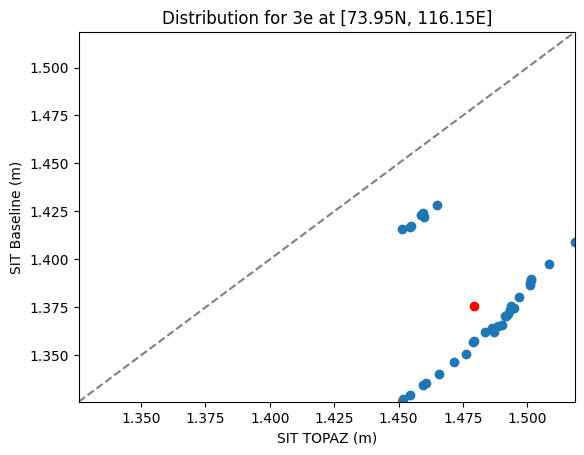

In [165]:
plt.scatter(pt_ml, pt_bl)
plt.scatter(np.mean(pt_ml), np.mean(pt_bl), c='r')

smin = np.min([pt_ml, pt_bl])
smax = np.max([pt_ml, pt_bl])
plt.xlim([smin, smax])
plt.ylim([smin, smax])

plt.plot([smin, smax], [smin, smax], ls='--', c='grey')

plt.xlabel('SIT TOPAZ (m)')
plt.ylabel('SIT Baseline (m)')


plt.title(f'Distribution for {camp} at [{dico_ice["Lat"][idx_pt]}N, {dico_ice["Lon"][idx_pt]}E]');

In [68]:
all_pts_ml = np.zeros((len(index[0]), 35))
all_pts_bl = np.zeros((len(index[0]), 35))


for ni, idx_pt in enumerate(index[0]):
    all_pts_ml[ni] = get_closest_mean_std(dico_ice['Lat'][idx_pt], dico_ice['Lon'][idx_pt], dt_min[idx_pt], dt_max[idx_pt], sit, chrono)
    all_pts_bl[ni] = get_closest_mean_std(dico_ice['Lat'][idx_pt], dico_ice['Lon'][idx_pt], dt_min[idx_pt], dt_max[idx_pt], sitm.sit_bl, chrono)    

In [88]:
all_pts_ml[100]

array([2.34258434, 2.33835725, 2.33062989, 2.33432807, 2.35777219,
       2.36672908, 2.37332824, 2.37813812, 2.41259815, 2.45651748,
       2.47368654, 2.48799648, 2.51651362, 2.54017812, 2.55625506,
       2.56905464, 2.57297861, 2.56958282, 2.56624445, 2.57311075,
       2.58391145, 2.62939249, 2.67844757, 2.68603702, 2.56708712,
       2.42168668, 2.39119161, 2.38487922, 2.3871318 , 2.39159532,
       2.3966545 , 2.40201703, 2.40531689, 2.40642452, 2.39578342])

In [89]:
all_pts_bl[100]

array([2.22285295, 2.22362256, 2.22221923, 2.23357177, 2.25878644,
       2.26689649, 2.2687943 , 2.21646857, 2.24855447, 2.29470134,
       2.31335998, 2.32913017, 2.3594327 , 2.38288498, 2.4008615 ,
       2.41360092, 2.41612339, 2.41029644, 2.4046216 , 2.40896225,
       2.41687822, 2.46198058, 2.5097425 , 2.51637149, 2.39648247,
       2.24843621, 2.21489286, 2.20542765, 2.20159554, 2.19808149,
       2.19914031, 2.20304036, 2.2055757 , 2.20487022, 2.19321704])

In [95]:
# rmse sur les 35 jours en chaque point
rmse = np.sqrt(np.mean(np.square(all_pts_ml-
                          all_pts_bl),axis=1))

In [169]:
# rmse average over 35 days
rmse_t = np.sqrt(np.nanmean(np.square(all_pts_ml-
                          all_pts_bl),axis=0))

In [105]:
bias = np.mean(all_pts_ml - all_pts_bl, axis=1)

In [101]:
from src.utils import quickplot

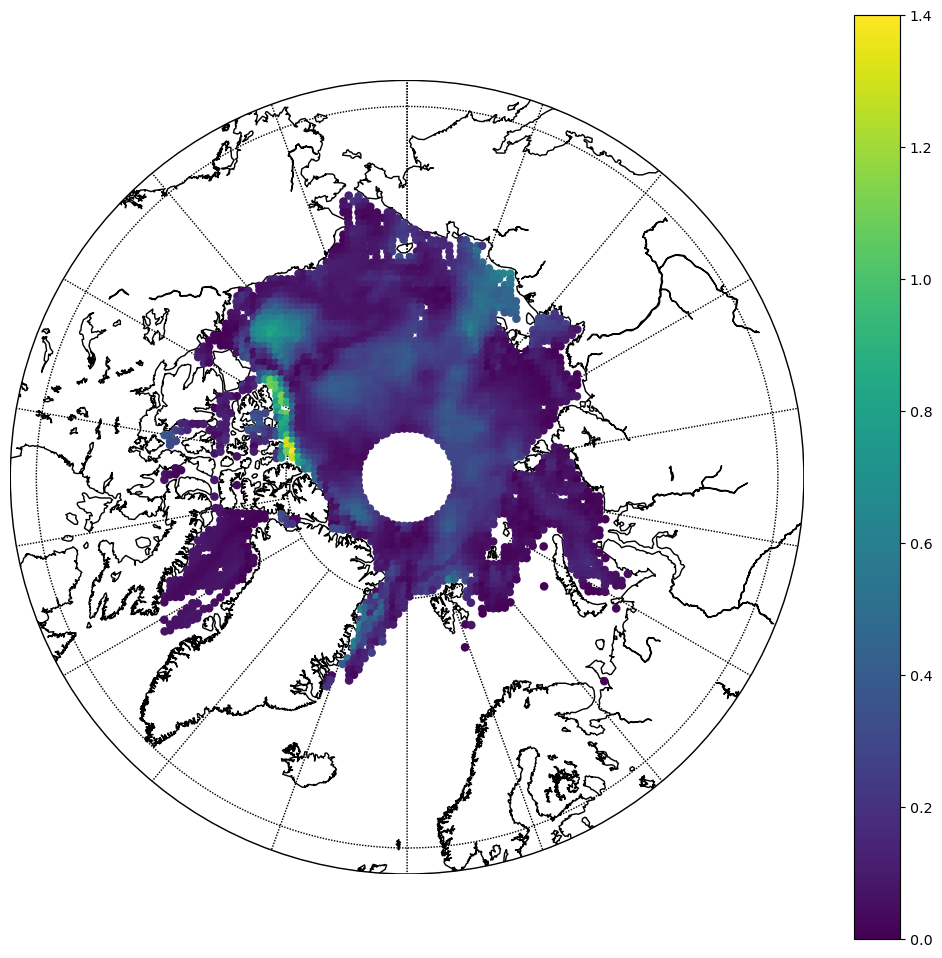

In [104]:
# rmse: ML - baseline, over all days in campaign
quickplot.basemap(lons, lats, rmse, vmin=0, vmax=1.4)

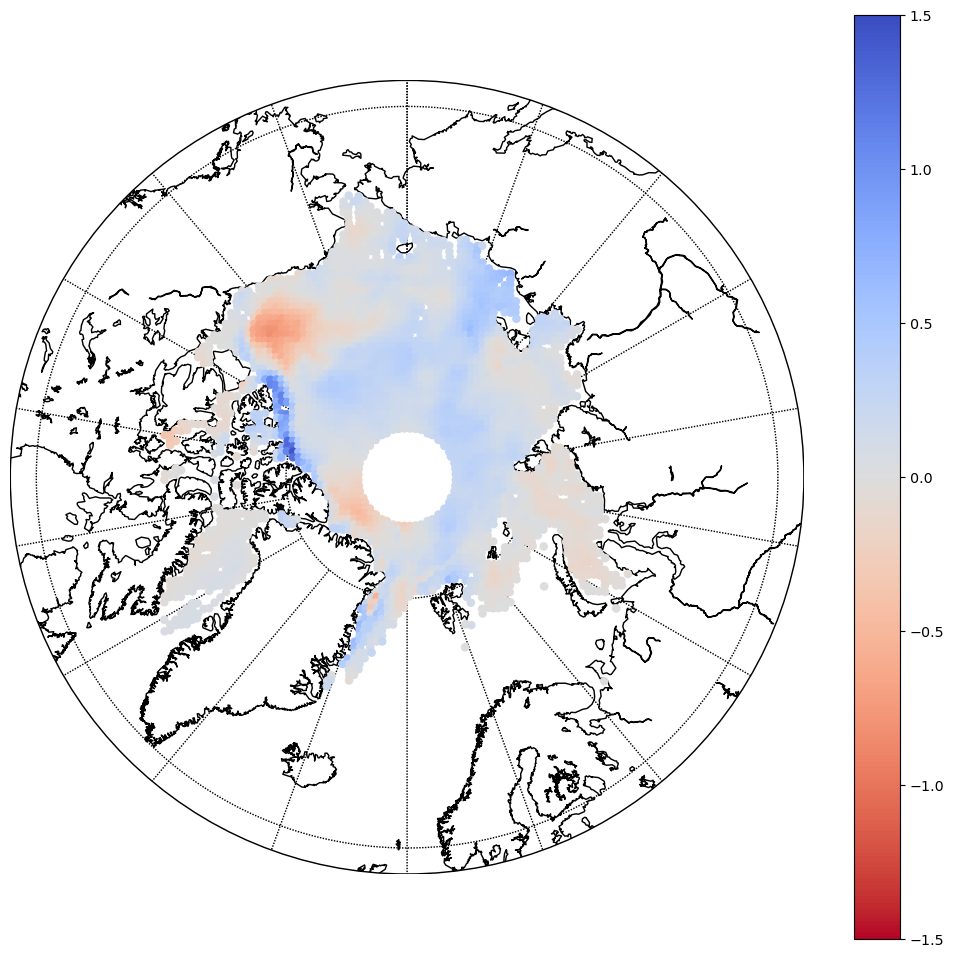

In [109]:
# bias: ML - baseline, over all days in campaign
quickplot.basemap(lons, lats, bias, vmin=-1.5, vmax=1.5, cmap=plt.get_cmap('coolwarm_r'))

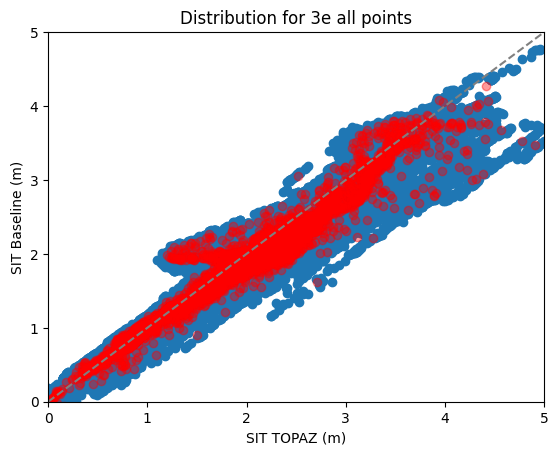

In [142]:
plt.scatter(all_pts_ml[:], all_pts_bl[:])
plt.scatter(np.mean(all_pts_ml, axis=1), np.mean(all_pts_bl, axis=1), c='r', alpha=0.4)

smin = 0
smax = 5
plt.xlim([smin, smax])
plt.ylim([smin, smax])

plt.plot([smin, smax], [smin, smax], ls='--', c='grey')

plt.xlabel('SIT TOPAZ (m)')
plt.ylabel('SIT Baseline (m)')


plt.title(f'Distribution for {camp} all points');

In [154]:
ndays = all_pts_ml.shape[1]-1

# daily mean
md_ml = np.nanmean(all_pts_ml,axis=0)
mstd_ml = np.nanstd(all_pts_ml,axis=0)

md_bl = np.nanmean(all_pts_bl,axis=0)
mstd_bl = np.nanstd(all_pts_bl,axis=0)

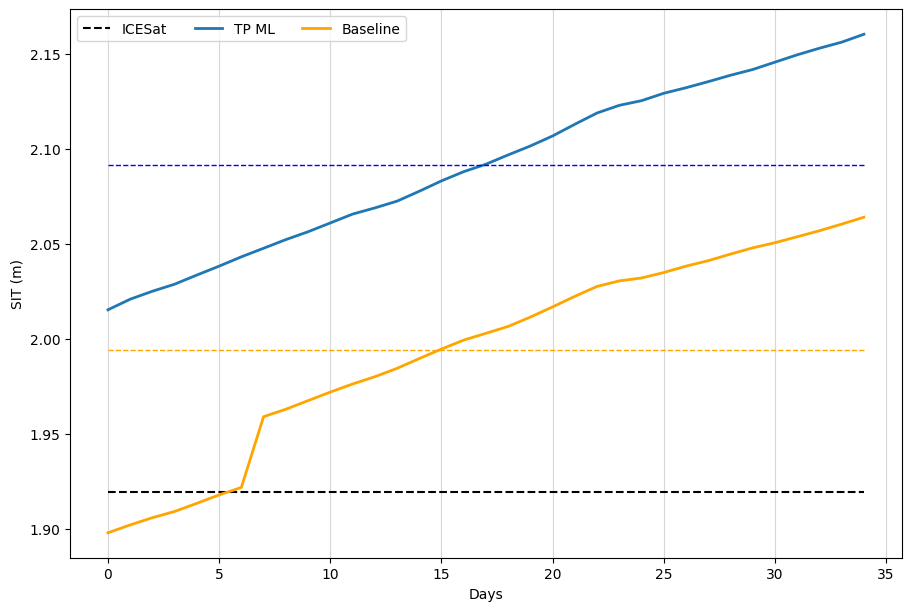

In [166]:
fig, ax = plt.subplots(figsize=(9, 6), constrained_layout=True)

plt.plot([0, ndays], [np.nanmean(sit_obs)]*2, label = 'ICESat', ls='--', c='k')

plt.plot(md_ml, label = 'TP ML', lw=2)
#plt.plot(md_ml+mstd_ml, c='b', alpha=0.4, label = '1 std')
#plt.plot(md_ml-mstd_ml, c='b', alpha=0.4)
plt.plot([0, ndays], [np.nanmean(all_pts_ml)]*2, lw=1, ls= '--', c='b')

plt.plot(md_bl, label = 'Baseline', lw=2, c='orange')
#plt.plot(md_bl+mstd_bl, c='orange', alpha=0.4, label = '1 std')
#plt.plot(md_bl-mstd_bl, c='orange', alpha=0.4)
plt.plot([0, ndays], [np.nanmean(all_pts_bl)]*2, lw=1, ls= '--', c='orange')


# plt.plot(all_pts_ml[1::20].T, c='b', alpha=0.4, zorder=-100)
# plt.plot(all_pts_bl[1::20].T, c='orange', alpha=0.4, zorder=-100)


plt.xlabel('Days')
plt.ylabel('SIT (m)')

plt.grid(axis='x', alpha=0.5)

plt.legend(ncols=3)

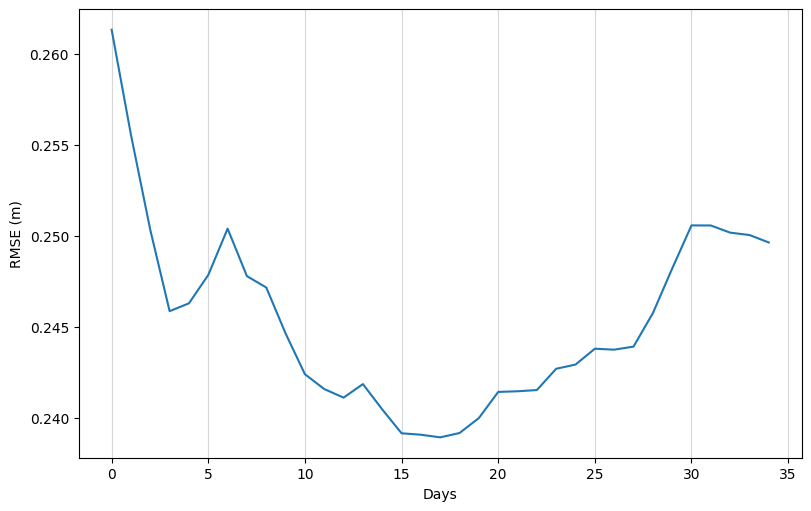

In [173]:
fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)

plt.plot(rmse_t)

plt.xlabel('Days')
plt.ylabel('RMSE (m)')

plt.grid(axis='x', alpha=0.5)

In [160]:
rmse.shape

(3131,)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


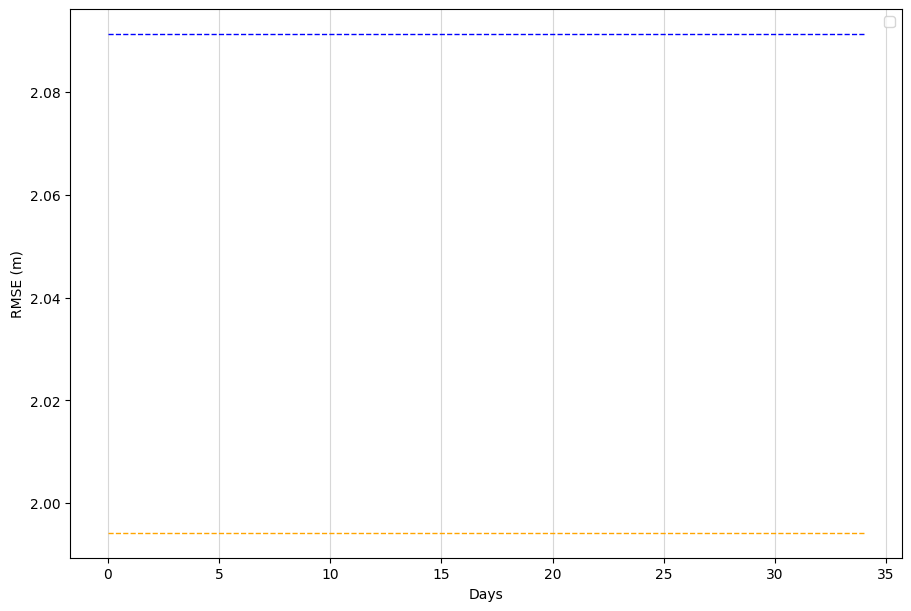

In [161]:
# same plot but with RMSE (reference is ICESat)
fig, ax = plt.subplots(figsize=(9, 6), constrained_layout=True)

# plt.plot(md_ml, label = 'TP ML', lw=2)
plt.plot([0, ndays], [np.nanmean(all_pts_ml)]*2, lw=1, ls= '--', c='b')

# plt.plot(md_bl, label = 'Baseline', lw=2, c='orange')
plt.plot([0, ndays], [np.nanmean(all_pts_bl)]*2, lw=1, ls= '--', c='orange')


plt.xlabel('Days')
plt.ylabel('RMSE (m)')

plt.grid(axis='x', alpha=0.5)

plt.legend(ncols=3)

Je veux montrer que la moyenne reduit les differences entre ML et baseline
<br>
et donc que la moyenne sur un mois n'est pas la maniere la plus claire pour montrer l'amelioration du produit ML par rapport a la baseline

## ----------------------------------

In [9]:
# -----------------------------------
#        Loop on campaigns
# -----------------------------------

print('Loading complete.')

camp = '3e'


index = np.where((dico_ice['Cruise']==camp))
t_min = np.min(dt_min[np.where(dico_ice['Cruise']==camp)])
t_max = np.max(dt_max[np.where(dico_ice['Cruise']==camp)])
print(f'Campaign {camp}: from {t_min} to {t_max}')

# Get TOPAZ data for all ICESAT points
tp_mean_std = np.zeros((len(index[0]),2))
tp_bl_mean_std = np.zeros((len(index[0]),2))

for ni, idx_pt in enumerate(index[0]):
    tp_mean_std[ni] = get_closest_mean_std(dico_ice['Lat'][idx_pt], dico_ice['Lon'][idx_pt], dt_min[idx_pt], dt_max[idx_pt], sit, chrono)
    tp_bl_mean_std[ni] = get_closest_mean_std(dico_ice['Lat'][idx_pt], dico_ice['Lon'][idx_pt], dt_min[idx_pt], dt_max[idx_pt], sitm.sit_bl, chrono)

# point returned as np.nan means that closest TOPAZ grid point is on land
idx_nan = np.unique(np.where(np.isnan(tp_mean_std))[0])
print(f'Lost points because on land in TOPAZ:  {idx_nan.size}')

#         Plot
# -----------------------------------
lons = dico_ice['Lon'][index]
lats = dico_ice['Lat'][index]
sit_obs = dico_ice['Avg_thkns'][index]
sit_tp = tp_mean_std[:,0]
sit_tp_bl = tp_bl_mean_std[:,0]

t_min = np.min(dt_min[np.where(dico_ice['Cruise']==camp)])
t_max = np.max(dt_max[np.where(dico_ice['Cruise']==camp)])
title = f'Campaign {camp}: from {t_min} to {t_max}'


Loading complete.
Campaign 3e: from 2006-02-22 to 2006-03-28


/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKK

/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKKY_KyB8utx/env1/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/LUMI_TYKK

Lost points because on land in TOPAZ:  34


In [16]:
t_min

datetime.date(2006, 2, 22)

In [17]:
t_max

datetime.date(2006, 3, 28)

In [19]:
len(index[0])

3131

In [22]:
sit_obs.shape

(3131,)

In [24]:
dico_ice['Avg_thkns'].shape

(29452,)

/tmp/ipykernel_195205/1719943804.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['0', '', '1','','2','','3','','4'])


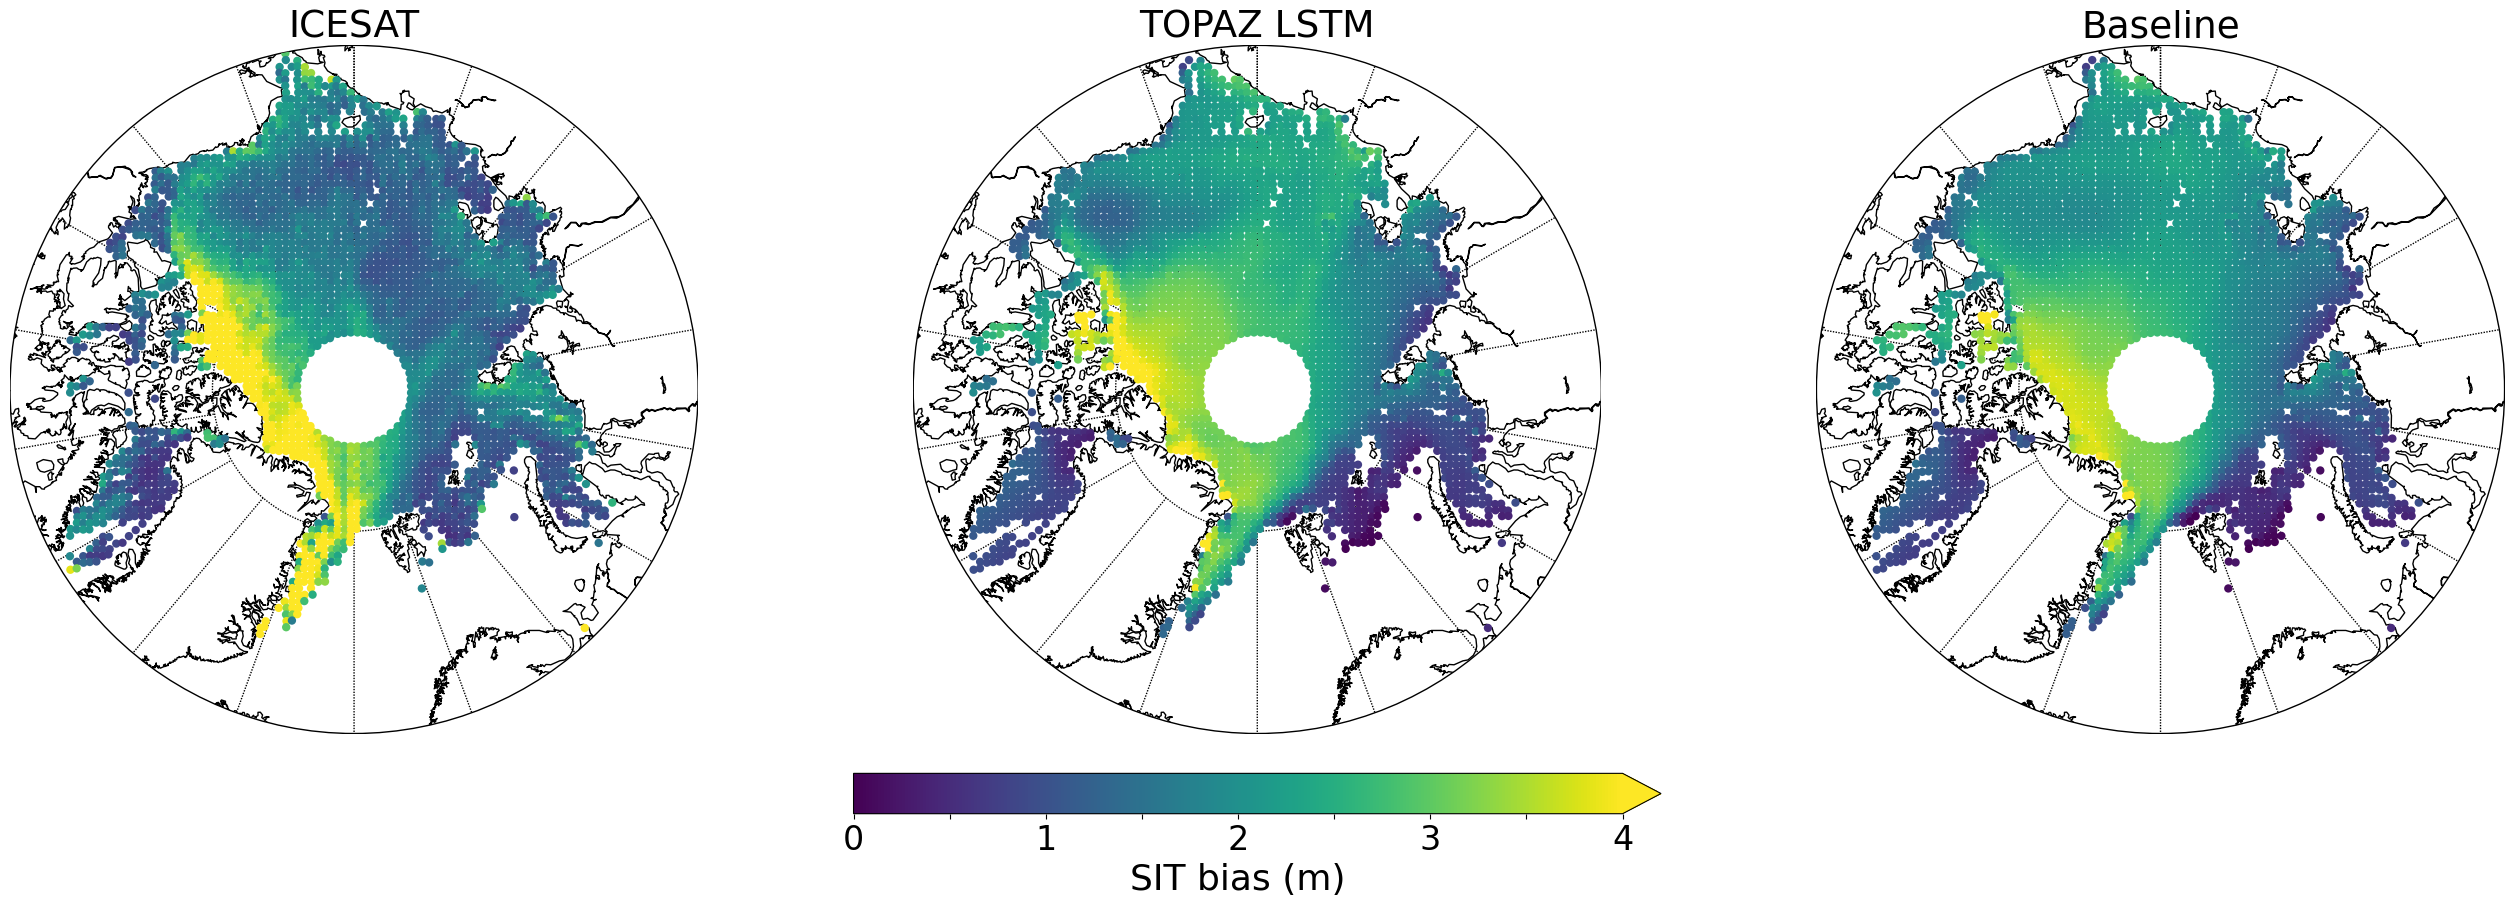

In [143]:
odir = f'{rootdir}Leo/results/SIT_observations/ICESAT/002/'
ofile = f'SIT_ICESAT_TOPAZLSTM_C{camp}_bs.png'

draw_sit_baseline(lats, lons, sit_obs, sit_tp, sit_tp_bl, vmin=0, vmax=4, odir=odir, ofile=ofile, savefig=False, showfig=True)

/tmp/ipykernel_195205/335042680.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(['-1', '', '-0.5','','0','','0.5','','1'])


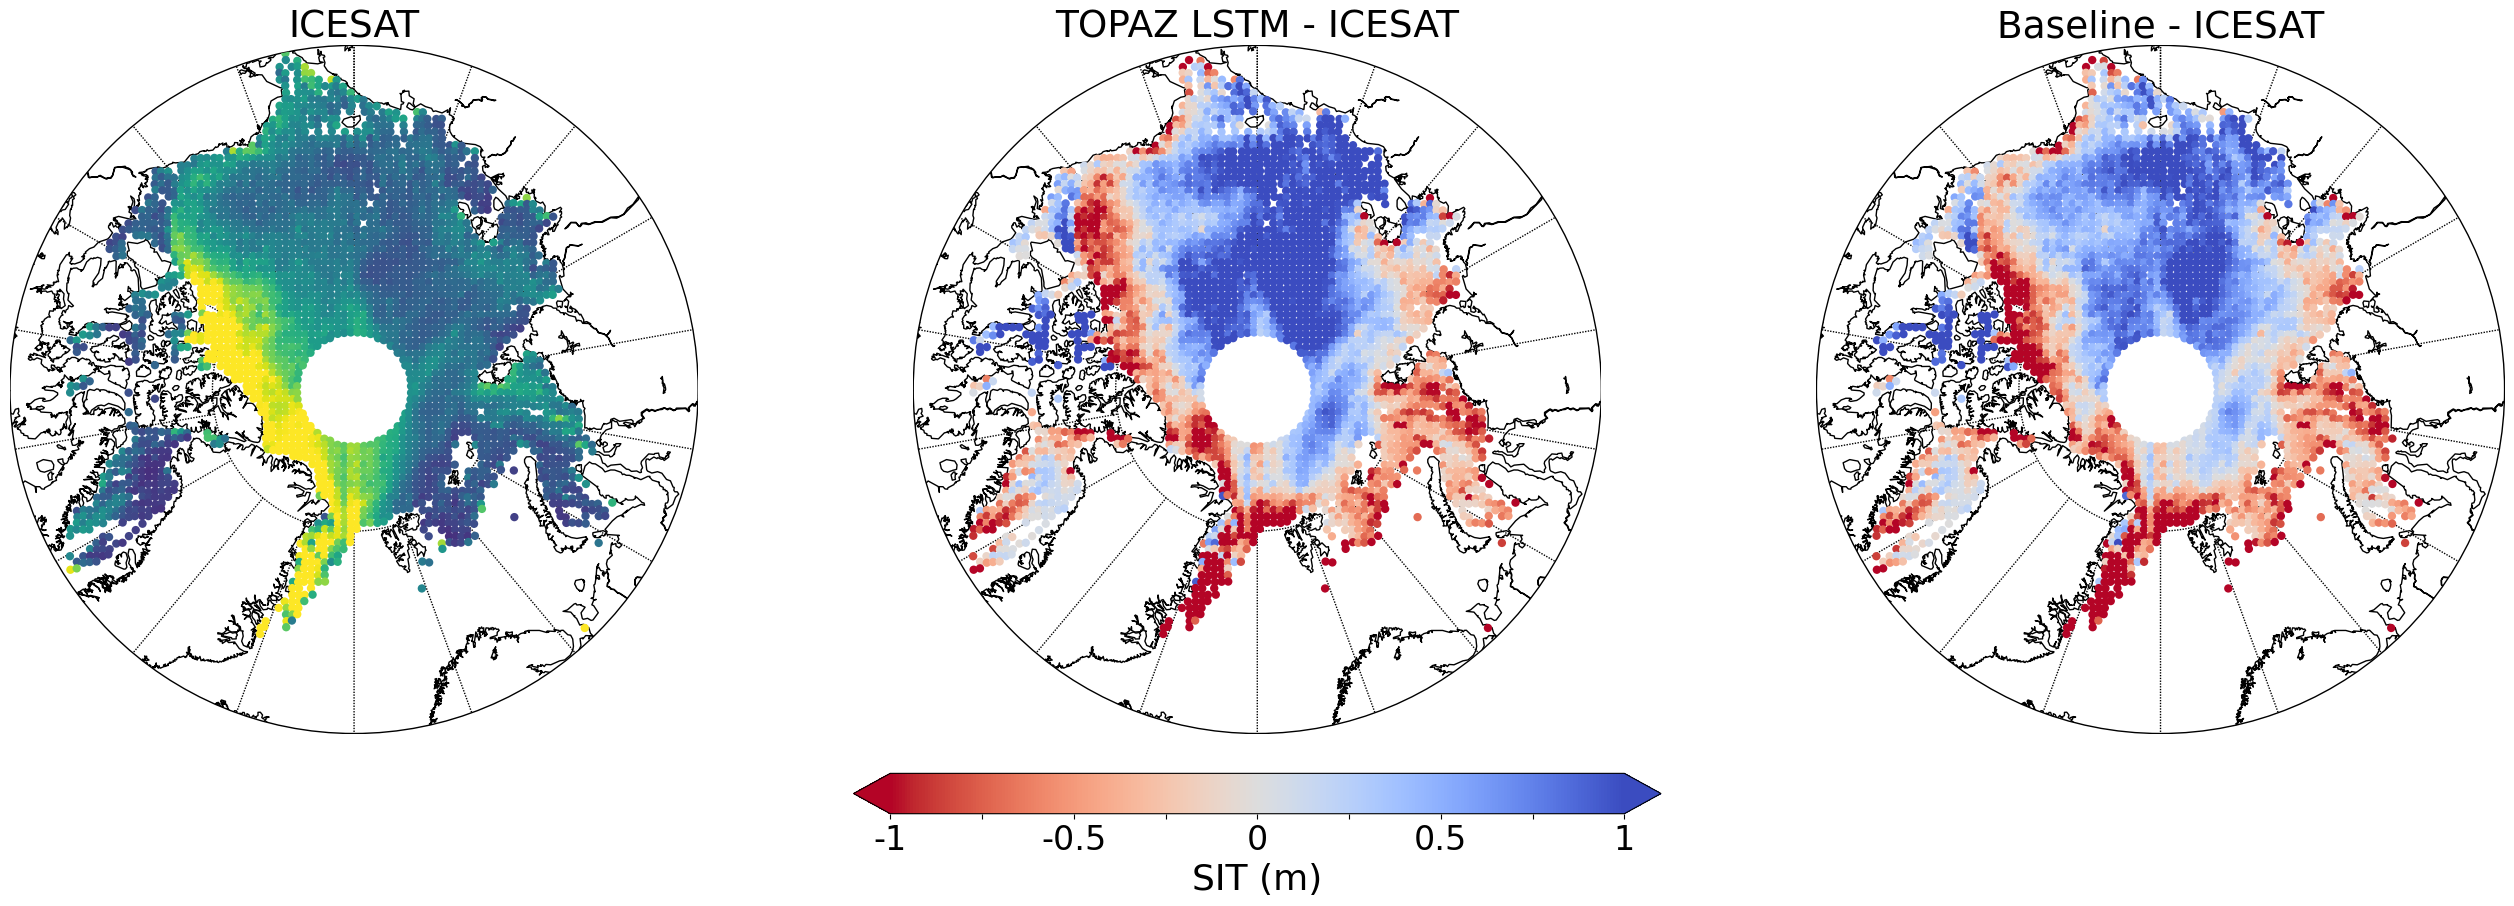

In [10]:
ofile = f'SITbias_ICESAT_TOPAZLSTM_C{camp}_bs.png'
draw_bias_baseline(lats, lons, sit_obs, sit_tp, sit_tp_bl, odir=odir, ofile=ofile, savefig=False, showfig=True)

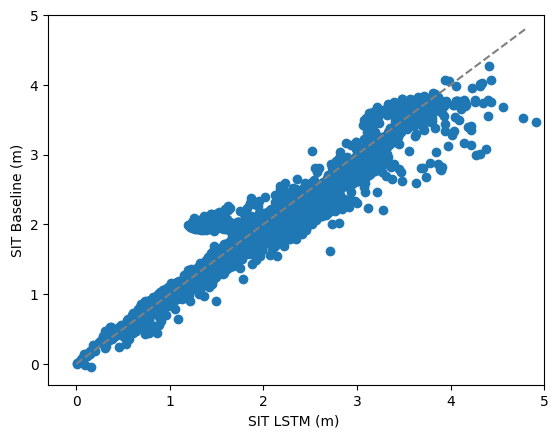

In [19]:
plt.scatter(sit_tp, sit_tp_bl)
plt.plot([0, 4.8], [0, 4.8], ls='--', c='grey')
plt.xlim([-0.3, 5])
plt.ylim([-0.3, 5])

plt.xlabel('SIT LSTM (m) ')
plt.ylabel('SIT Baseline (m)');

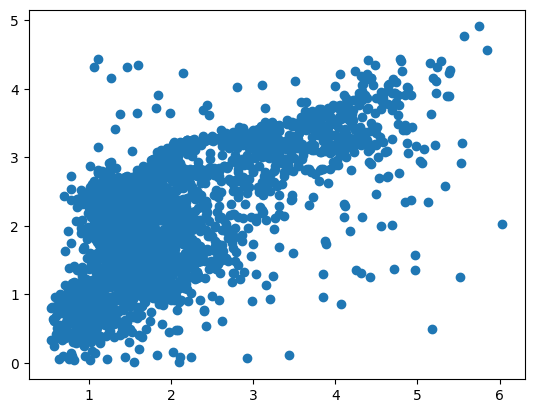

In [28]:
plt.scatter(sit_obs, sit_tp)

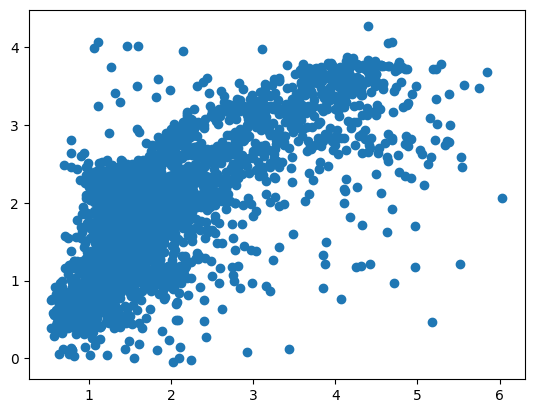

In [29]:
plt.scatter(sit_obs, sit_tp_bl)